<a href="https://colab.research.google.com/github/SarahAncheta/data100/blob/main/Data100_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Questions**
1. How have early confinement policies affected the spread of COVID-19?
2. Does climate have an effect on the amount of COVID-19 cases? Could warmer summer temperatures help stop the spread of the virus?
3. Does a state's political party affiliation have an effect on the number of COVID-19 cases?

_(Saw these 3 questions in the chat, not sure which 2 we want to choose.)_

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

In [ ]:
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_county = 'https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv'
url_county_time = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
# Timeseries data on number of US deaths starting 1/22/20, updated daily
#df_deaths = pd.read_csv(url_deaths)

# Timeseries data on number of US confirmed cases starting 1/22/20, updated daily
#df_confirmed = pd.read_csv(url_confirmed)

# Timeseries data on number of US cases/deaths starting 1/25/20, by county
df_county_time = pd.read_csv(url_county_time)

# General county data including demographics, heathcare resources, social distancing
# Column descriptors available at: https://github.com/Yu-Group/covid19-severity-prediction/blob/master/data/list_of_columns.md
df_county = pd.read_csv(url_county)

#EDA

In [ ]:
df_county_time.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [ ]:
df_county.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944

In [ ]:
df_county_time.isnull().sum()
df_county.isnull().sum()

countyFIPS               0
STATEFP                 23
COUNTYFP                23
CountyName               0
StateName                0
                      ... 
foreign travel ban      25
SVIPercentile          104
HPSAShortage          1141
HPSAServedPop         1141
HPSAUnderservedPop    1141
Length: 87, dtype: int64

# Data Cleaning

In [ ]:
# Cleaned df for county cases/deaths timeseries
time_clean = df_county_time.drop('fips', axis = 1)
time_clean['date'] = pd.to_datetime(time_clean['date'])

In [ ]:
# Choose columns deemed potentially important in df_county
df_clean_county = df_county[['CountyName', 'State','#EligibleforMedicare2018','MedicareEnrollment,AgedTot2017', 
                             '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017', 
                             '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'stay at home', '>50 gatherings', '>500 gatherings', 
                             'public schools', 'restaurant dine-in', 'entertainment/gym', 'federal guidelines', 
                             'foreign travel ban', 'SVIPercentile','PopulationEstimate2018']]

In [ ]:
# ELLESE TRIES TO CONSOLIDATE THE CODE
# IF ALL GOES WELL, THIS CAN REPLACE ALL THE BOTTOM CODE CHUNKS...
    
# States we want to choose. Change this list to change which states and code will automatically clean for those states
states = ['California', 'Florida', 'Pennsylvania']

# Create new column to track the number of days since first case was observed
time_clean = time_clean[time_clean['state'].isin(states)]
time_clean['# days since first case'] = np.zeros(time_clean.shape[0])

for i in states:
  counties = time_clean.loc[time_clean['state'] == i]['county'].unique()
  for j in counties:
    time_clean.loc[(time_clean['county'] == j) & (time_clean['state'] == i), ['# days since first case']] = \
    [k + 1 for k in range(0, time_clean.loc[(time_clean['county'] == j) & (time_clean['state'] == i)].shape[0])]

In [ ]:
# ELLESE STILL TRYING TO CONSOLIDATE CODE

big_df = df_clean_county[df_clean_county['State'].isin(states)]
big_df = big_df.rename({'CountyName': 'county', 'State':'state'}, axis = 1)

# Convert ordinal dates to # of days ince first policy was enacted
distancing = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 
              'entertainment/gym', 'federal guidelines', 'foreign travel ban']
for i in distancing:
  big_df.loc[i] = big_df[i] - big_df[i].min()

# Merge time series and county data
big_df = big_df.merge(time_clean, on=['county', 'state'])

big_df['proportion deaths'] = big_df['deaths'] / big_df['PopulationEstimate2018']
big_df['proportion cases'] = big_df['cases'] / big_df['PopulationEstimate2018']

big_df.head()

,county,state,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,PopulationEstimate2018,date,cases,deaths,# days since first case,proportion deaths,proportion cases
0,Alameda,California,253144.0,206830.0,18353.0,6636.0,6.0,12.0,282.0,5.367298,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.4701,1666753.0,2020-03-01,1,0,1.0,0.0,5.999689e-07
1,Alameda,California,253144.0,206830.0,18353.0,6636.0,6.0,12.0,282.0,5.367298,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.4701,1666753.0,2020-03-02,1,0,2.0,0.0,5.999689e-07
2,Alameda,California,253144.0,206830.0,18353.0,6636.0,6.0,12.0,282.0,5.367298,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.4701,1666753.0,2020-03-03,2,0,3.0,0.0,1.199938e-06
3,Alameda,California,253144.0,206830.0,18353.0,6636.0,6.0,12.0,282.0,5.367298,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.4701,1666753.0,2020-03-04,2,0,4.0,0.0,1.199938e-06
4,Alameda,California,253144.0,206830.0,18353.0,6636.0,6.0,12.0,282.0,5.367298,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.4701,1666753.0,2020-03-05,2,0,5.0,0.0,1.199938e-06


# NOTE FROM ELLESE
### The two cells above should now be sufficient to replace the data cleaning cells below. 

### You will need to filter from `big_df` to get specific data if you want _just_ one state

In [ ]:
#filter dataset to only include counties in California, all 58
cali_clean = df_clean_county[df_clean_county['State'] == 'California']
florida_clean = df_clean_county[df_clean_county['State'] == 'Florida']

#found columns with null values
cali_clean.isnull().sum()
florida_clean.isnull().sum()

#dropped columns with a lot of null values 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop' and 'mortality2015-17Estimated'
#also removed 'STATEFP', 'StateName', 'State', 'foreign travel ban' and 'federal guidelines', since consistent across all of california

cali_clean = cali_clean.drop(['STATEFP', 'State', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop', 'mortality2015-17Estimated', 'federal guidelines', 'foreign travel ban'], axis = 1)
florida_clean = florida_clean.drop(['STATEFP', 'State', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop', 'mortality2015-17Estimated', 'federal guidelines', 'foreign travel ban'], axis = 1)
#soclean
cali_is_so_clean = cali_clean[['CountyName', 'dem_to_rep_ratio', 'SVIPercentile','stay at home','PopulationEstimate2018']]
florida_is_so_clean = florida_clean[['CountyName', 'dem_to_rep_ratio', 'SVIPercentile','stay at home','PopulationEstimate2018']]

florida_is_so_clean

KeyError: ignored

In [ ]:
#time data for California
cali_time = time_clean[time_clean['state'] == 'California']
florida_time = time_clean[time_clean['state'] == 'Florida']

#Number of days since the first case in the time data
cali_time['# days since first case'] = np.zeros(cali_time.shape[0])
florida_time['# days since first case'] = np.zeros(florida_time.shape[0])

for i in cali_time['county'].unique():
    cali_time.loc[cali_time['county'] == i, ['# days since first case']] = [i + 1 for i in range(0, cali_time.loc[cali_time['county'] == i].shape[0])]

for i in florida_time['county'].unique():
    florida_time.loc[florida_time['county'] == i, ['# days since first case']] = [i + 1 for i in range(0, florida_time.loc[florida_time['county'] == i].shape[0])]

#join together time series and county data based on county for California
cali_covid = cali_clean.set_index('CountyName').join(cali_time.set_index('county'))
florida_covid = florida_clean.set_index('CountyName').join(florida_time.set_index('county'))

#cleanincovid
cali_so_clean_covid = cali_is_so_clean.set_index('CountyName').join(cali_time.set_index('county'))
florida_so_clean_covid = florida_is_so_clean.set_index('CountyName').join(florida_time.set_index('county'))

#soclean but #proportioned
cali_so_clean_covid['proportion cases'] = cali_so_clean_covid['cases'] / cali_so_clean_covid['PopulationEstimate2018']
cali_so_clean_covid['proportion deaths'] = cali_so_clean_covid['deaths'] / cali_so_clean_covid['PopulationEstimate2018']
florida_so_clean_covid['proportion cases'] = florida_so_clean_covid['cases'] / florida_so_clean_covid['PopulationEstimate2018']
florida_so_clean_covid['proportion deaths'] = florida_so_clean_covid['deaths'] / florida_so_clean_covid['PopulationEstimate2018']

In [ ]:
#clean Pennsylvania data, drop columns with NA values
penn_clean = df_clean_county[df_clean_county['State'] == 'Pennsylvania'].drop(['STATEFP', 'State', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop', 'mortality2015-17Estimated', 'federal guidelines', 'foreign travel ban'], axis = 1)
penn_time = time_clean[time_clean['state'] == 'Pennsylvania']

# Add number of days since first case
penn_time['# days since first case'] = np.zeros(penn_time.shape[0])
for i in penn_time['county'].unique():
    penn_time.loc[penn_time['county'] == i, ['# days since first case']] = [i + 1 for i in range(0, penn_time.loc[penn_time['county'] == i].shape[0])]

penn_covid = penn_clean.set_index('CountyName').join(penn_time.set_index('county'))

#create new column
penn_covid['proportion cases by stay'] = (penn_covid.groupby('stay at home')['cases'].transform('sum'))/(penn_covid.groupby('stay at home')['PopulationEstimate2018'].transform('sum'))

# Visualizations

In [ ]:
#GRAPHS!!!yay
#(penn_covid.groupby('stay at home')['cases'].transform('sum')).unique()#/(penn_covid.groupby('stay at home')['PopulationEstimate2018'].transform('sum'))

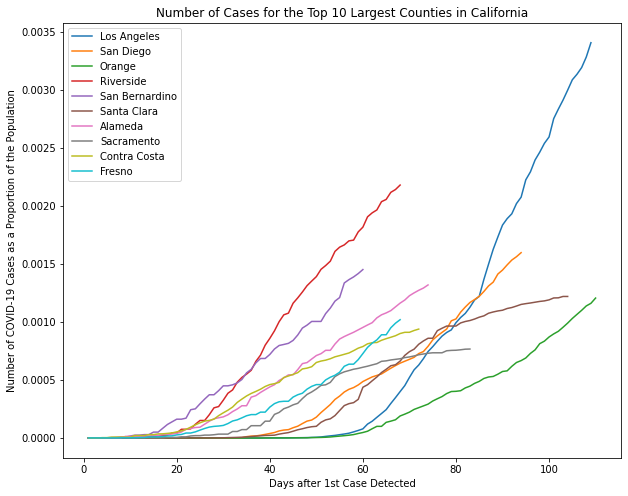

In [ ]:
# Visual of number of cases for top largest counties in California (by population)
top_ten = big_df.loc[big_df['state'] == 'California'].sort_values(by = 'PopulationEstimate2018', ascending = False)['county'].unique()[0:10]

plt.figure(figsize=(10, 8))
for i in top_ten:
    curr = big_df.loc[(big_df['county'] == i) & (big_df['state'] == 'California')]
    plt.plot(curr['# days since first case'], curr['proportion cases'], label = i);
    
plt.legend()
plt.title('Number of Cases for the Top 10 Largest Counties in California')
plt.ylabel('Number of COVID-19 Cases as a Proportion of the Population')
plt.xlabel('Days after 1st Case Detected')
plt.savefig('ca_counties_cases.png')

Text(0, 0.5, 'Proportion of Population that has tested positive for COVID-19')

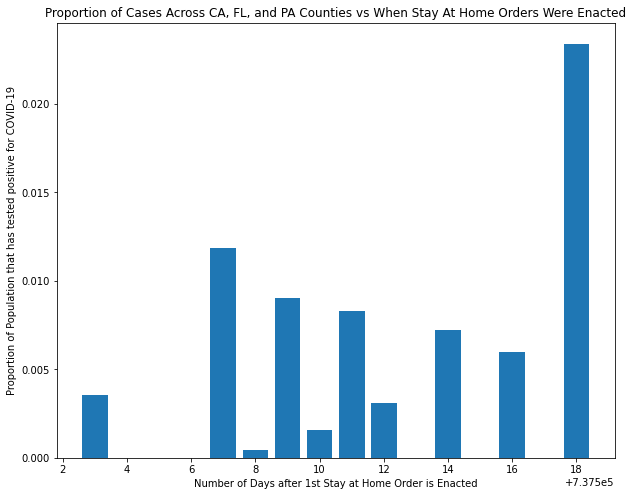

In [ ]:
grouped_df = big_df.groupby('county').max()

plt.figure(figsize=(10, 8))
plt.bar(grouped_df['stay at home'], grouped_df['proportion cases'])
plt.title('Proportion of Cases Across CA, FL, and PA Counties vs When Stay At Home Orders Were Enacted')
plt.xlabel('Number of Days after 1st Stay at Home Order is Enacted')
plt.ylabel('Proportion of Population that has tested positive for COVID-19')

In [ ]:
#random 10 counties, florida, sorted
random_ten = big_df.loc[big_df['state'] == 'Florida']['county'].sample(10)
florida_random_sorted = big_df.loc[(big_df['county'].isin(random_ten)) & (big_df['state'] == 'Florida')].sort_values(by=['dem_to_rep_ratio'])
florida_random_sorted = florida_random_sorted.groupby('county').max().reset_index()
florida_random_sorted

,county,state,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,PopulationEstimate2018,date,cases,deaths,# days since first case,proportion deaths,proportion cases
0,Alachua,Florida,45942.0,35453.0,14498.0,2978.0,0.0,2.0,210.0,1.618909,737509.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.4729,269956.0,2020-05-13,326,5,65.0,0.000019,0.001208
1,Bay,Florida,40969.0,30400.0,2768.0,448.0,0.0,2.0,77.0,0.350468,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.6076,185287.0,2020-05-13,77,3,54.0,0.000016,0.000416
2,Hamilton,Florida,3066.0,2231.0,0.0,3.0,0.0,0.0,0.0,0.553006,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.9908,14310.0,2020-05-13,86,0,38.0,0.000000,0.006010
3,Holmes,Florida,5142.0,3718.0,149.0,15.0,0.0,1.0,0.0,0.113992,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.9347,19477.0,2020-05-13,10,0,45.0,0.000000,0.000513
4,Jefferson,Florida,3750.0,2918.0,0.0,9.0,0.0,0.0,0.0,0.901018,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.5748,14288.0,2020-05-13,28,2,40.0,0.000140,0.001960
5,Liberty,Florida,1439.0,1007.0,0.0,0.0,0.0,0.0,0.0,0.255997,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.8334,8457.0,2020-05-13,198,0,34.0,0.000000,0.023413
6,Madison,Florida,4544.0,3361.0,138.0,9.0,0.0,1.0,0.0,0.726860,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.9608,18529.0,2020-05-13,61,3,43.0,0.000162,0.003292
7,Marion,Florida,120523.0,94424.0,4908.0,804.0,0.0,2.0,110.0,0.575343,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.7535,359977.0,2020-05-13,217,5,54.0,0.000014,0.000603
8,Okaloosa,Florida,42952.0,32907.0,2691.0,613.0,1.0,3.0,57.0,0.330769,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.3860,207269.0,2020-05-13,169,5,68.0,0.000024,0.000815
9,Suwannee,Florida,11787.0,8932.0,177.0,25.0,0.0,1.0,0.0,0.277455,737518.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.9424,44191.0,2020-05-13,149,18,48.0,0.000407,0.003372


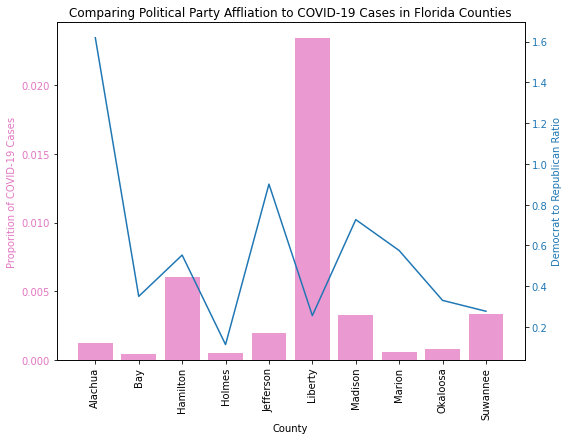

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting florida_random_sorted - shows us dem to rep on a graph w proportion of cases

# FROM ELLESE: I changed the proportion of cases to a bar graph. The reason it looked strange as a line graph was because a point
# was being plotted for every single day for that county. Instead I took the number of cases from the most recent day and plotted that
# You can choose if you want to do that for the california graph as well. 

# Also I slightly modified the code to get 10 random counties to use the dataframe I made to consolidate data cleaning

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:pink'
ax1.set_xlabel('County')
ax1.set_ylabel('Proporition of COVID-19 Cases', color=color)
ax1.bar(florida_random_sorted['county'], florida_random_sorted['proportion cases'], color=color, alpha = 0.75)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Democrat to Republican Ratio', color=color)  
ax2.plot(florida_random_sorted['county'], florida_random_sorted['dem_to_rep_ratio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Comparing Political Party Affliation to COVID-19 Cases in Florida Counties') 
plt.show()
plt.savefig('dem_rep.png')


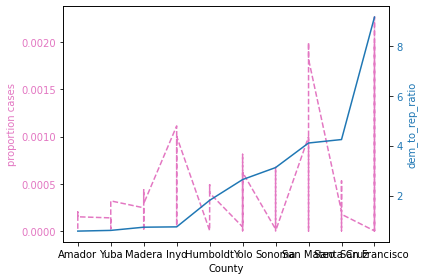

In [ ]:
#random 10 counties, florida, sorted
warnings.filterwarnings('ignore')
random_ten = big_df.loc[big_df['state'] == 'California']['county'].sample(10)
california_random_sorted = big_df.loc[(big_df['county'].isin(random_ten)) & (big_df['state'] == 'California')].sort_values(by=['dem_to_rep_ratio'])

#plotting florida_random_sorted - shows us dem to rep on a graph w proportion of cases

fig, ax1 = plt.subplots()

color = 'tab:pink'
ax1.set_xlabel('County')
ax1.set_ylabel('proportion cases', color=color)
ax1.plot(california_random_sorted['county'], california_random_sorted['proportion cases'], color=color,linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('dem_to_rep_ratio', color=color)  
ax2.plot(california_random_sorted['county'], california_random_sorted['dem_to_rep_ratio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  

plt.show()

In [ ]:
penn_covid = big_df[big_df['county'] == 'Pennsylvania']
x = penn_covid['stay at home'].unique()
y = penn_covid['proportion cases by stay'].unique()

x = [datetime.fromordinal(i) for i in penn_stay_dates]

y = penn_covid['proportion cases by stay'].unique()
plt.figure(figsize=(20,10))
plt.bar(x, y)
plt.xlabel('State Date of Shelter in Place Order')
plt.ylabel('Proportion of Cases')
plt.title('Start Date of Stay at Home vs. Proportion of Cases in Pennsylvania')


KeyError: ignored

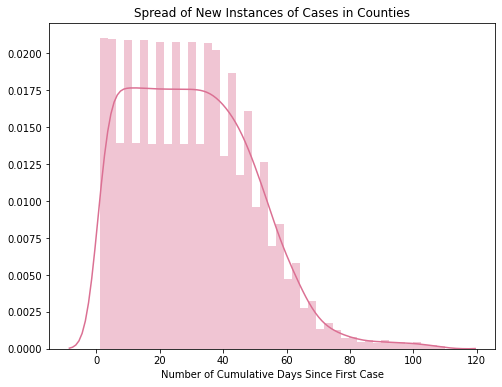

In [ ]:
plt.figure(figsize=(8, 6))
sns.distplot(big_df['# days since first case'], axlabel = "Number of Cumulative Days Since First Case", color = "palevioletred")
plt.title('Spread of New Instances of Cases in Counties')
plt.savefig('hist.png')

#Models

### Linear Regression Model Using `dem_to_rep_ratio`

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import sklearn.model_selection

#Calculate the error
def rmse(prediction, actual):
    return np.sqrt(np.mean((actual - prediction) ** 2))

In [ ]:
#One simple model: Predicting the number of cases using the dem_to_rep_ratio and Population estimate
#Create a dataset that isn't a time series
grouped_three = big_df.groupby('county').max().reset_index()
lr_model_1_df = grouped_three[['dem_to_rep_ratio', 'proportion cases', 'county']].dropna()
#Creating train and test set
train, test = sklearn.model_selection.train_test_split(lr_model_1_df, train_size=0.8, test_size=0.2, random_state=42)
X_train = train[['dem_to_rep_ratio']]
X_test = test[['dem_to_rep_ratio']]
Y_train = train['proportion cases']
Y_test = test['proportion cases']

#A constant model for sake of comparison
constant_rmse = rmse(Y_test, np.mean(Y_test))

#Fitting our model
simple_model = LinearRegression()
simple_model.fit(X_train, Y_train)
pred = simple_model.predict(X_test)
dem_to_rep_rmse = rmse(pred, Y_test)

print('RMSE of constant model: {} \nRMSE of dem_to_rep model {}'.format(constant_rmse, dem_to_rep_rmse))

RMSE of constant model: 0.0015139412921815509 
RMSE of dem_to_rep model 0.0016632641690844585


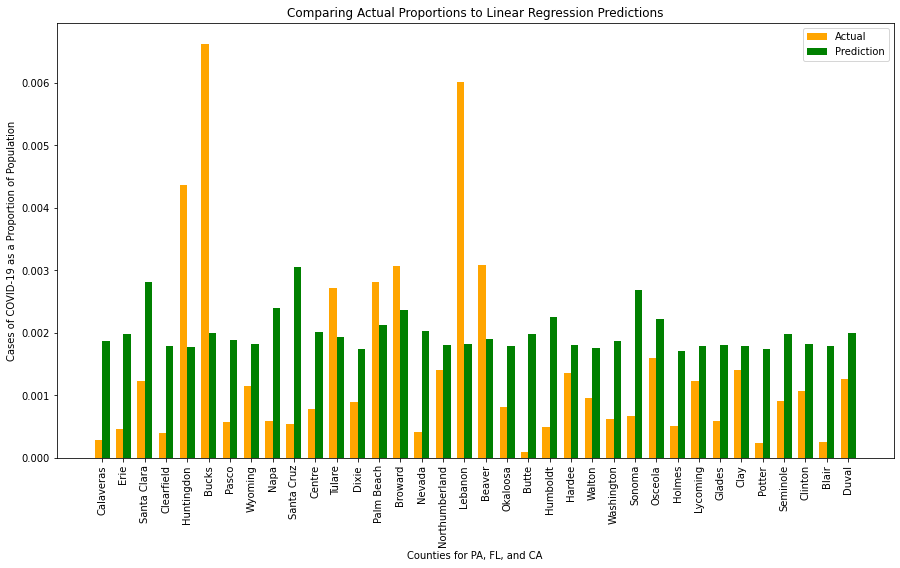

In [ ]:
N = len(Y_test)
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize =(15,8))
rects1 = ax.bar(ind, Y_test, width, color = 'orange', label = 'Actual')
rects2 = ax.bar(ind+width, pred, width, color = 'green', label = 'Prediction')

ax.set_ylabel('Cases of COVID-19 as a Proportion of Population')
ax.set_title('Comparing Actual Proportions to Linear Regression Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(test['county'], rotation = 90)
ax.set_xlabel('Counties for PA, FL, and CA')
plt.legend()

This  model we used just 1 feature, namely `dem_to_rep_ratio` which represents the ration between Democrats and Republicans in a particular county. We are interested in seeing if political affiliations play a role in the number of cases that a county sees. Comparing the RMSEs between our constant model and that which uses `dem_to_rep_ratio`, we unfortunately get a smaller RMSE with our constant model. Looking at the graph, our model predicts somewhat similar values for all counties. Namely, Clearfield and Huntingdon counties have drastic differences in the number of cases but our model only predicts nearly the same proportion for both counties.

In [ ]:
grouped_three.columns
lr_model_2_df = grouped_three[['stay at home', '>50 gatherings', '>500 gatherings',
       'public schools', 'restaurant dine-in', 'entertainment/gym', 'cases', 'PopulationEstimate2018', 'county', 'proportion cases']].dropna()

train, test = sklearn.model_selection.train_test_split(lr_model_2_df, train_size=0.8, test_size=0.2, random_state=42)
X_train = train[['stay at home', 'PopulationEstimate2018', '>50 gatherings']]
X_test = test[['stay at home', 'PopulationEstimate2018', '>50 gatherings']]
Y_train = train['cases']
Y_test = test['cases']

#A constant model for sake of comparison
constant_rmse = rmse(Y_test, np.mean(Y_test))

#Fitting our model
social_distancing_model = LinearRegression()
social_distancing_model.fit(X_train, Y_train)
pred = social_distancing_model.predict(X_test)

social_distancing_rmse = rmse(test['proportion cases'], pred/X_test['PopulationEstimate2018'])

constant_rmse = rmse(test['proportion cases'], np.mean(Y_test)/X_test['PopulationEstimate2018'])

print('RMSE of constant model: {} \nRMSE of social_distancing model {}'.format(constant_rmse, social_distancing_rmse))

RMSE of constant model: 0.015546763088882013 
RMSE of social_distancing model 0.011972370840164231


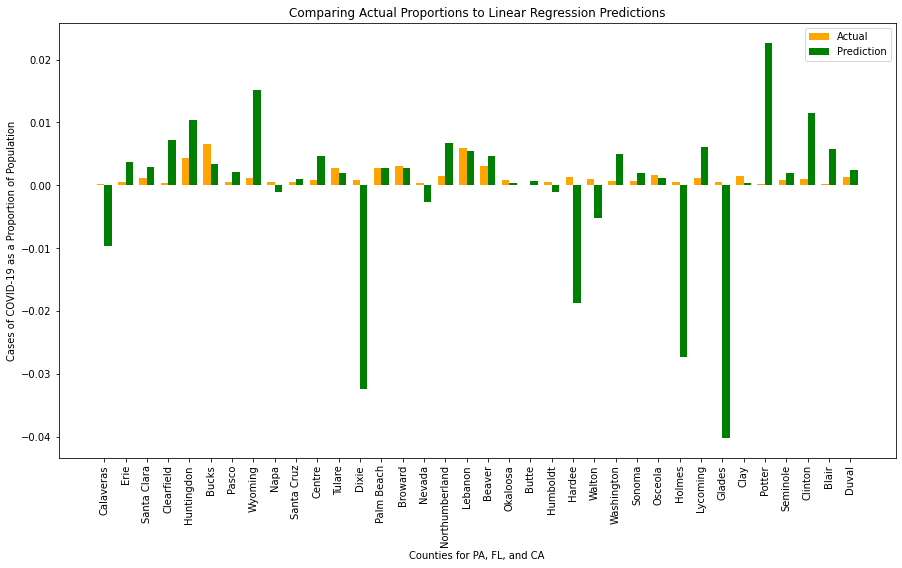

In [ ]:
N = len(Y_test)
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize =(15,8))
rects1 = ax.bar(ind, Y_test/test['PopulationEstimate2018'], width, color = 'orange', label = 'Actual')
rects2 = ax.bar(ind+width, pred/test['PopulationEstimate2018'], width, color = 'green', label = 'Prediction')

ax.set_ylabel('Cases of COVID-19 as a Proportion of Population')
ax.set_title('Comparing Actual Proportions to Linear Regression Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(test['county'], rotation = 90)
ax.set_xlabel('Counties for PA, FL, and CA')
plt.legend()

Interestingly, when we predict the total number of cases rather than the cases as a _proportion_ of population, it appears on the surface that we get a better model. Inspecting the graph comparing our predictions to our truth values, we see that many of our predictions are negative. So while our RMSE is smaller, this model is not useful as it is not meaningful to have the proportion of COVID-19 cases be a negative number.

In [ ]:
grouped_three.columns
lr_model_3_df = grouped_three[['PopulationEstimate2018', '#EligibleforMedicare2018', '#Hospitals',	'#ICU_beds', 'county', 'proportion cases', 'cases']].dropna()

train, test = sklearn.model_selection.train_test_split(lr_model_3_df, train_size=0.8, test_size=0.2, random_state=42)
X_train = train[['#EligibleforMedicare2018', '#Hospitals',	'#ICU_beds']]
X_test = test[['#EligibleforMedicare2018', '#Hospitals',	'#ICU_beds']]
Y_train = train['proportion cases']
Y_test = test['proportion cases']

#A constant model for sake of comparison
constant_rmse = rmse(Y_test, np.mean(Y_test))

#Fitting our model
healthcare_model = LinearRegression()
healthcare_model.fit(X_train, Y_train)
pred = healthcare_model.predict(X_test)

healthcare_rmse = rmse(Y_test, pred)

print('RMSE of constant model: {} \nRMSE of healthcare model {}'.format(constant_rmse, healthcare_rmse))

RMSE of constant model: 0.0015139412921815509 
RMSE of healthcare model 0.0016582249377872934


In [ ]:
#One simple model: Predicting the number of cases using the dem_to_rep_ratio and Population estimate
#Create a dataset that isn't a time series
grouped_three = big_df[big_df['state'] == 'Florida'].groupby('county').max().reset_index()
lr_model_4_df = grouped_three[['dem_to_rep_ratio', 'proportion cases', 'county']].dropna()
#Creating train and test set
train, test = sklearn.model_selection.train_test_split(lr_model_4_df, train_size=0.8, test_size=0.2, random_state=42)
X_train = train[['dem_to_rep_ratio']]
X_test = test[['dem_to_rep_ratio']]
Y_train = train['proportion cases']
Y_test = test['proportion cases']

#A constant model for sake of comparison
constant_rmse = rmse(Y_test, np.mean(Y_test))

#Fitting our model
simple_model = LinearRegression()
simple_model.fit(X_train, Y_train)
pred = simple_model.predict(X_test)
dem_to_rep_rmse = rmse(pred, Y_test)

print('RMSE of constant model: {} \nRMSE of dem_to_rep model {}'.format(constant_rmse, dem_to_rep_rmse))

RMSE of constant model: 0.00595310312084068 
RMSE of dem_to_rep model 0.006215647510566053


In [ ]:
#One simple model: Predicting the number of cases using the dem_to_rep_ratio and Population estimate
#Create a dataset that isn't a time series
grouped_three = big_df.groupby('county').max().reset_index()
lr_model_4_df = grouped_three[['dem_to_rep_ratio', 'SVIPercentile', '#ICU_beds', 'MedicareEnrollment,AgedTot2017', 'proportion cases', 'county']].dropna()
#Creating train and test set
train, test = sklearn.model_selection.train_test_split(lr_model_4_df, train_size=0.8, test_size=0.2, random_state=42)
X_train = train[['dem_to_rep_ratio', 'SVIPercentile', '#ICU_beds', 'MedicareEnrollment,AgedTot2017']]
X_test = test[['dem_to_rep_ratio', 'SVIPercentile', '#ICU_beds', 'MedicareEnrollment,AgedTot2017']]
Y_train = train['proportion cases']
Y_test = test['proportion cases']

#A constant model for sake of comparison
constant_rmse = rmse(Y_test, np.mean(Y_test))

#Fitting our model
simple_model = LinearRegression()
simple_model.fit(X_train, Y_train)
pred = simple_model.predict(X_test)
dem_to_rep_rmse = rmse(pred, Y_test)

print('RMSE of constant model: {} \nRMSE of dem_to_rep model 2 {}'.format(constant_rmse, dem_to_rep_rmse))

RMSE of constant model: 0.0015139412921815509 
RMSE of dem_to_rep model 2 0.001707970879076972


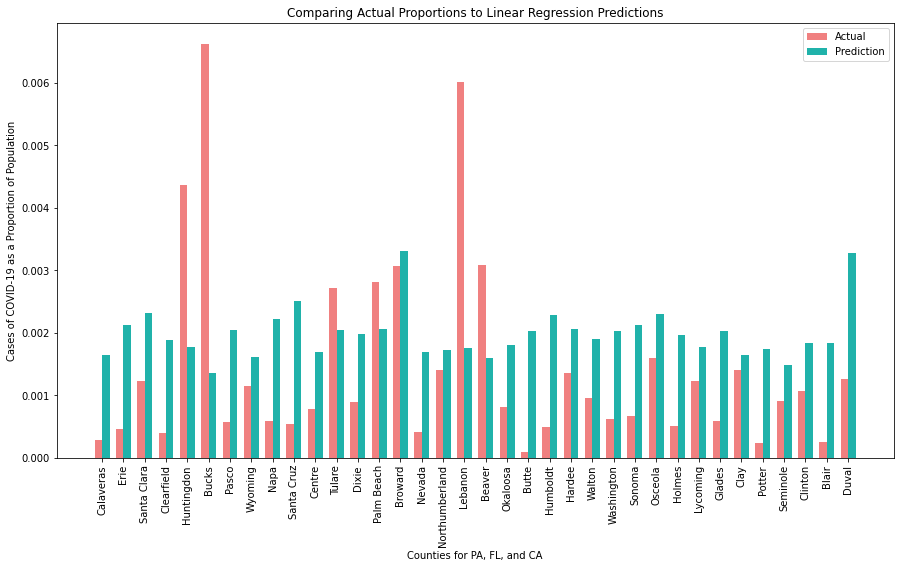

In [ ]:
N = len(Y_test)
ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize =(15,8))
rects1 = ax.bar(ind, Y_test, width, color = 'lightcoral', label = 'Actual')
rects2 = ax.bar(ind+width, pred, width, color = 'lightseagreen', label = 'Prediction')

ax.set_ylabel('Cases of COVID-19 as a Proportion of Population')
ax.set_title('Comparing Actual Proportions to Linear Regression Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(test['county'], rotation = 90)
ax.set_xlabel('Counties for PA, FL, and CA')
plt.legend()